## **Day 2: Classification and Clustering – Movement Prediction and Market Patterns :**

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_classif , RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier

from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split , GridSearchCV , RandomizedSearchCV , TimeSeriesSplit, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_auc_score , roc_curve, auc , classification_report

## **Classification :**

### *Data Loading and Cleaning :*

In [2]:
df = pd.read_csv(r'cleaned_data.csv')
df.shape

(2738, 18)

In [3]:
df = df.drop(columns=['day','returns','target'])

In [4]:
df = df.set_index('timestamp')

In [5]:
df.head()

,open,high,low,close,volume,year,sma,ema,bbh,bbm,bbl,volatility,rsi,close_mom_7
timestamp,,,,,,,,,,,,,,
2018-01-14,14210.00,14339.50,12569.20,13474.99,17017.89,2018,14506.92,14370.08,16249.23,14506.92,12764.61,940.96,49.66,-0.17
2018-01-15,13477.98,14249.99,13147.79,13539.93,14652.09,2018,14124.77,14146.31,15356.54,14124.77,12893.00,665.23,44.25,-0.17
2018-01-16,13500.00,13542.93,9035.00,10900.00,63401.17,2018,13930.11,13994.71,15032.60,13930.11,12827.63,595.41,44.83,-0.09
2018-01-17,10899.99,11680.99,9037.94,10988.79,72331.80,2018,13430.11,13221.04,15740.08,13430.11,11120.15,1247.52,30.94,-0.24
2018-01-18,10972.59,11878.82,10435.33,10961.97,48464.43,2018,12870.36,12662.97,15368.72,12870.36,10371.99,1349.27,31.71,-0.26


In [6]:
df['next_day_close'] = df['close'].shift(-1)
df['target'] = (df['next_day_close'] > df['close']).astype(int)

In [7]:
df.head()

,open,high,low,close,volume,year,sma,ema,bbh,bbm,bbl,volatility,rsi,close_mom_7,next_day_close,target
timestamp,,,,,,,,,,,,,,,,
2018-01-14,14210.00,14339.50,12569.20,13474.99,17017.89,2018,14506.92,14370.08,16249.23,14506.92,12764.61,940.96,49.66,-0.17,13539.93,1
2018-01-15,13477.98,14249.99,13147.79,13539.93,14652.09,2018,14124.77,14146.31,15356.54,14124.77,12893.00,665.23,44.25,-0.17,10900.00,0
2018-01-16,13500.00,13542.93,9035.00,10900.00,63401.17,2018,13930.11,13994.71,15032.60,13930.11,12827.63,595.41,44.83,-0.09,10988.79,1
2018-01-17,10899.99,11680.99,9037.94,10988.79,72331.80,2018,13430.11,13221.04,15740.08,13430.11,11120.15,1247.52,30.94,-0.24,10961.97,0
2018-01-18,10972.59,11878.82,10435.33,10961.97,48464.43,2018,12870.36,12662.97,15368.72,12870.36,10371.99,1349.27,31.71,-0.26,11474.98,1


In [8]:
df.tail()

,open,high,low,close,volume,year,sma,ema,bbh,bbm,bbl,volatility,rsi,close_mom_7,next_day_close,target
timestamp,,,,,,,,,,,,,,,,
2025-07-10,111241.23,117238.05,110513.28,115983.04,5235.34,2025,109058.45,109121.88,111146.61,109058.45,106970.29,1127.73,62.40,0.02,117520.28,1
2025-07-11,116004.58,118842.56,115218.77,117520.28,3110.92,2025,109972.12,110837.17,115288.26,109972.12,104655.98,2871.04,70.95,0.06,117389.09,0
2025-07-12,117525.07,118201.67,116920.15,117389.09,1914.06,2025,111334.41,112507.95,118485.42,111334.41,104183.40,3861.99,73.09,0.09,119047.16,1
2025-07-13,117425.06,119482.23,117221.37,119047.16,1386.36,2025,112647.40,113728.23,120365.47,112647.40,104929.33,4168.24,72.60,0.08,119853.11,1
2025-07-14,119076.50,123199.44,118905.17,119853.11,4025.97,2025,114054.14,115057.97,122316.45,114054.14,105791.83,4462.16,74.90,0.09,NaN,0


In [9]:
df.dropna(inplace =True)

### *Data Splitting :*

In [10]:
df

,open,high,low,close,volume,year,sma,ema,bbh,bbm,bbl,volatility,rsi,close_mom_7,next_day_close,target
timestamp,,,,,,,,,,,,,,,,
2018-01-14,14210.00,14339.50,12569.20,13474.99,17017.89,2018,14506.92,14370.08,16249.23,14506.92,12764.61,940.96,49.66,-0.17,13539.93,1
2018-01-15,13477.98,14249.99,13147.79,13539.93,14652.09,2018,14124.77,14146.31,15356.54,14124.77,12893.00,665.23,44.25,-0.17,10900.00,0
2018-01-16,13500.00,13542.93,9035.00,10900.00,63401.17,2018,13930.11,13994.71,15032.60,13930.11,12827.63,595.41,44.83,-0.09,10988.79,1
2018-01-17,10899.99,11680.99,9037.94,10988.79,72331.80,2018,13430.11,13221.04,15740.08,13430.11,11120.15,1247.52,30.94,-0.24,10961.97,0
2018-01-18,10972.59,11878.82,10435.33,10961.97,48464.43,2018,12870.36,12662.97,15368.72,12870.36,10371.99,1349.27,31.71,-0.26,11474.98,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-09,108924.10,111998.05,108328.13,111246.58,2605.12,2025,108712.78,108413.65,109797.75,108712.78,107627.82,585.95,56.59,0.03,115983.04,1
2025-07-10,111241.23,117238.05,110513.28,115983.04,5235.34,2025,109058.45,109121.88,111146.61,109058.45,106970.29,1127.73,62.40,0.02,117520.28,1
2025-07-11,116004.58,118842.56,115218.77,117520.28,3110.92,2025,109972.12,110837.17,115288.26,109972.12,104655.98,2871.04,70.95,0.06,117389.09,0


In [11]:
final_df = df.drop(columns= ['close','next_day_close'])
final_df.head(1)

,open,high,low,volume,year,sma,ema,bbh,bbm,bbl,volatility,rsi,close_mom_7,target
timestamp,,,,,,,,,,,,,,
2018-01-14,14210.00,14339.50,12569.20,17017.89,2018,14506.92,14370.08,16249.23,14506.92,12764.61,940.96,49.66,-0.17,1


In [12]:
train_df = final_df[final_df['year'].between(2018, 2022)]
test_df = final_df[final_df['year'] == 2023]
forecast_df = final_df[final_df['year'] >= 2024]

In [13]:
train_df = train_df.drop(columns=['year'])
test_df = test_df.drop(columns=['year'])
forecast_df = forecast_df.drop(columns=['year'])

In [14]:
X_train, y_train = train_df.drop(columns=['target']), train_df['target']
X_test, y_test = test_df.drop(columns=['target']), test_df['target']
X_forecast, y_forecast = forecast_df.drop(columns=['target']), forecast_df['target']

In [15]:
X_train.shape , y_train.shape , X_test.shape , y_test.shape , X_forecast.shape , y_forecast.shape

((1812, 12), (1812,), (365, 12), (365,), (560, 12), (560,))

In [16]:
X_train.shape , y_train.shape , X_test.shape , y_test.shape , X_forecast.shape , y_forecast.shape

((1812, 12), (1812,), (365, 12), (365,), (560, 12), (560,))

### *Standardization*


In [17]:
X_train.shape , y_train.shape , X_test.shape , y_test.shape , X_forecast.shape , y_forecast.shape

((1812, 12), (1812,), (365, 12), (365,), (560, 12), (560,))

In [18]:
X_train.head(1)

,open,high,low,volume,sma,ema,bbh,bbm,bbl,volatility,rsi,close_mom_7
timestamp,,,,,,,,,,,,
2018-01-14,14210.00,14339.50,12569.20,17017.89,14506.92,14370.08,16249.23,14506.92,12764.61,940.96,49.66,-0.17


In [19]:
# X_train[['low','volume','bbh','volatility','rsi','close_mom_7']]

In [20]:
# scaler = StandardScaler()

In [21]:
# joblib.dump(scaler,'clf_x_scaler.pkl')

In [22]:
scaler = joblib.load('clf_x_scaler.pkl')

In [23]:
X_train.head(1)

,open,high,low,volume,sma,ema,bbh,bbm,bbl,volatility,rsi,close_mom_7
timestamp,,,,,,,,,,,,
2018-01-14,14210.00,14339.50,12569.20,17017.89,14506.92,14370.08,16249.23,14506.92,12764.61,940.96,49.66,-0.17


In [24]:
y_train.head()

timestamp
2018-01-14    1
2018-01-15    0
2018-01-16    1
2018-01-17    0
2018-01-18    1
Name: target, dtype: int64

In [25]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_forecast_scaled = scaler.transform(X_forecast)

In [26]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
X_forecast_scaled = pd.DataFrame(X_forecast_scaled, columns=X_forecast.columns, index=X_forecast.index)

In [27]:
X_train_scaled

,open,high,low,volume,sma,ema,bbh,bbm,bbl,volatility,rsi,close_mom_7
timestamp,,,,,,,,,,,,
2018-01-14,-0.36,-0.38,-0.43,-0.65,-0.34,-0.35,-0.30,-0.34,-0.39,0.19,-0.07,-1.70
2018-01-15,-0.40,-0.38,-0.40,-0.69,-0.37,-0.37,-0.35,-0.37,-0.38,-0.13,-0.47,-1.70
2018-01-16,-0.40,-0.42,-0.65,0.08,-0.38,-0.37,-0.37,-0.38,-0.39,-0.21,-0.43,-0.93
2018-01-17,-0.56,-0.53,-0.65,0.22,-0.41,-0.42,-0.33,-0.41,-0.49,0.55,-1.44,-2.37
2018-01-18,-0.55,-0.52,-0.56,-0.16,-0.44,-0.45,-0.35,-0.44,-0.54,0.67,-1.39,-2.57
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,-0.20,-0.22,-0.19,1.78,-0.21,-0.21,-0.27,-0.21,-0.14,-0.86,-0.15,0.23
2022-12-28,-0.21,-0.24,-0.20,2.06,-0.21,-0.21,-0.27,-0.21,-0.14,-0.84,-0.43,-0.15
2022-12-29,-0.22,-0.24,-0.20,1.57,-0.21,-0.21,-0.26,-0.21,-0.15,-0.77,-0.62,-0.25


In [28]:
X_train_scaled.shape , X_test_scaled.shape , X_forecast_scaled.shape , y_train.shape , y_test.shape , y_forecast.shape

((1812, 12), (365, 12), (560, 12), (1812,), (365,), (560,))

### *Feature selection [Corr , Mutual info, RFE , VIF]*
* Important Futures - ['low','volume','bbh','rsi','volatility','close_mom_7']
* But used - ['open', 'high', 'low', 'volume', 'sma', 'ema', 'bbh', 'bbm', 'bbl','volatility', 'rsi', 'close_mom_7']

In [29]:
train_df.corr()

,open,high,low,volume,sma,ema,bbh,bbm,bbl,volatility,rsi,close_mom_7,target
open,1.00,1.00,1.00,-0.12,1.00,1.00,0.99,1.00,1.00,0.77,0.08,0.06,-0.03
high,1.00,1.00,1.00,-0.11,1.00,1.00,0.99,1.00,0.99,0.78,0.08,0.06,-0.03
low,1.00,1.00,1.00,-0.12,0.99,1.00,0.99,0.99,0.99,0.76,0.08,0.06,-0.04
volume,-0.12,-0.11,-0.12,1.00,-0.11,-0.11,-0.11,-0.11,-0.11,-0.08,-0.06,-0.04,-0.02
sma,1.00,1.00,0.99,-0.11,1.00,1.00,1.00,1.00,1.00,0.78,0.04,0.01,-0.03
ema,1.00,1.00,1.00,-0.11,1.00,1.00,1.00,1.00,1.00,0.78,0.04,0.01,-0.03
bbh,0.99,0.99,0.99,-0.11,1.00,1.00,1.00,1.00,0.99,0.81,0.04,0.00,-0.03
bbm,1.00,1.00,0.99,-0.11,1.00,1.00,1.00,1.00,1.00,0.78,0.04,0.01,-0.03
bbl,1.00,0.99,0.99,-0.11,1.00,1.00,0.99,1.00,1.00,0.74,0.04,0.01,-0.03
volatility,0.77,0.78,0.76,-0.08,0.78,0.78,0.81,0.78,0.74,1.00,0.02,-0.03,-0.03


<Axes: >

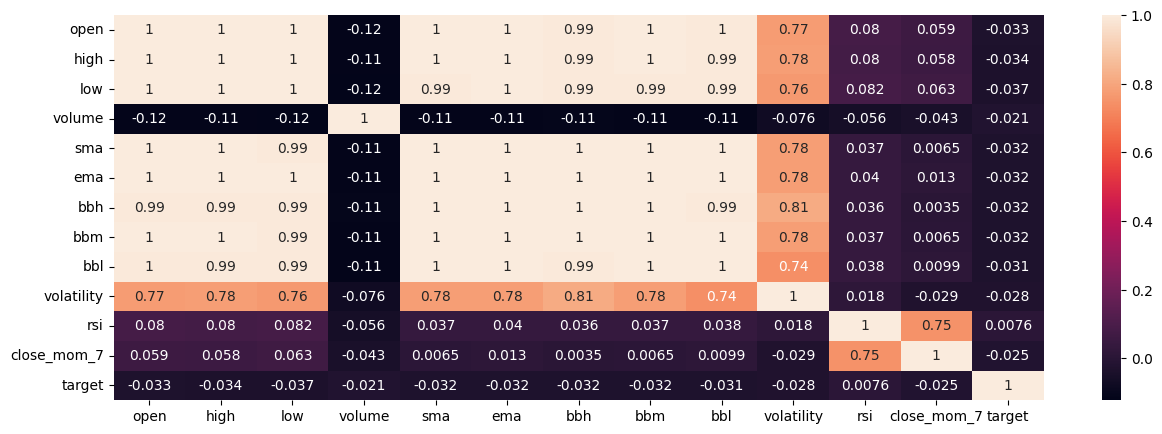

In [30]:
plt.figure(figsize=(15,5))
sns.heatmap(train_df.corr(),annot = True)

In [31]:
sel_feat = mutual_info_classif(X_train_scaled,y_train)
sel_feat

array([0.        , 0.        , 0.00093702, 0.        , 0.01034864,
       0.01076548, 0.        , 0.01042748, 0.        , 0.00755939,
       0.01199555, 0.        ])

In [32]:
imp_feat = pd.Series(sel_feat)
imp_feat.index = X_train_scaled.columns
imp_feat.sort_values(ascending=False)

rsi           0.01
ema           0.01
bbm           0.01
sma           0.01
volatility    0.01
low           0.00
open          0.00
high          0.00
volume        0.00
bbh           0.00
bbl           0.00
close_mom_7   0.00
dtype: float64

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE

In [34]:
n_features = 7
rfe_results = {}

models = {
    "LogisticRegression": LogisticRegression(),
    "RandomForest": RandomForestClassifier(random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42)
}

In [35]:
for name, model in models.items():
    rfe = RFE(estimator= model, n_features_to_select= n_features)
    rfe.fit(X_train_scaled, y_train)
    
    selected = X_train_scaled.columns[rfe.support_].tolist()
    rfe_results[name] = selected
    print(f"Selected Features via RFE ({name}):\n{selected}")

Selected Features via RFE (LogisticRegression):
['open', 'low', 'volume', 'ema', 'bbl', 'rsi', 'close_mom_7']
Selected Features via RFE (RandomForest):
['high', 'low', 'volume', 'bbh', 'bbl', 'volatility', 'rsi']
Selected Features via RFE (DecisionTree):
['high', 'low', 'volume', 'bbh', 'volatility', 'rsi', 'close_mom_7']


In [36]:
rfe_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in rfe_results.items()]))
print("RFE Feature Comparison Table:")
rfe_df

RFE Feature Comparison Table:


,LogisticRegression,RandomForest,DecisionTree
0,open,high,high
1,low,low,low
2,volume,volume,volume
3,ema,bbh,bbh
4,bbl,bbl,volatility
5,rsi,volatility,rsi
6,close_mom_7,rsi,close_mom_7


In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [38]:
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

In [39]:
vif_df = calculate_vif(X_train_scaled)
print(vif_df.sort_values(by='VIF', ascending=False))

        feature              VIF
7           bbm              inf
4           sma              inf
6           bbh 9887156152295.27
8           bbl 6971516451037.92
9    volatility   79608280198.16
5           ema          7039.79
0          open          1356.52
1          high           851.37
2           low           441.11
11  close_mom_7             2.90
10          rsi             2.58
3        volume             1.04


### *Lasy classifier :*

In [40]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , recall_score , precision_score

In [41]:
X_train_scaled.shape , X_test_scaled.shape , X_forecast_scaled.shape , y_train.shape , y_test.shape , y_forecast.shape

((1812, 12), (365, 12), (560, 12), (1812,), (365,), (560,))

In [42]:
X_train_scaled , X_eval_scaled , y_train2 , y_eval = train_test_split(X_train_scaled,y_train,test_size = 0.2, random_state = 34)
X_train_scaled.shape , X_eval_scaled.shape , y_train2.shape , y_eval.shape

((1449, 12), (363, 12), (1449,), (363,))

In [43]:
print(X_train_scaled.shape , X_eval_scaled.shape , X_test_scaled.shape , X_forecast_scaled.shape)
print(y_train2.shape , y_eval.shape , y_test.shape , y_forecast.shape)

(1449, 12) (363, 12) (365, 12) (560, 12)
(1449,) (363,) (365,) (560,)


In [44]:
# ['open', 'low', 'volume', 'ema', 'bbl', 'rsi', 'close_mom_7']

In [45]:
X_train_imp = X_train_scaled[['low','volume','bbh','rsi','volatility','close_mom_7']]
X_eval_imp = X_eval_scaled[['low','volume','bbh','rsi','volatility','close_mom_7']]
X_test_imp = X_test_scaled[['low','volume','bbh','rsi','volatility','close_mom_7']]
X_forecast_imp = X_test_scaled[['low','volume','bbh','rsi','volatility','close_mom_7']]

In [46]:
X_train_imp.head()

,low,volume,bbh,rsi,volatility,close_mom_7
timestamp,,,,,,
2019-08-09,-0.49,-0.30,-0.51,1.00,-0.20,1.49
2019-02-05,-0.99,-0.52,-1.00,-0.59,-0.88,0.04
2018-12-01,-0.96,-0.21,-0.95,-1.71,-0.71,-0.93
2021-10-10,2.09,-0.53,1.96,1.25,2.40,1.39
2020-07-02,-0.65,-0.20,-0.68,-0.21,-0.79,-0.15


In [47]:
def custom_recall(y_true, y_pred):
    return recall_score(y_true, y_pred, average='weighted')

def custom_precision(y_true, y_pred):
    return precision_score(y_true, y_pred, average='weighted')

In [48]:
clf = LazyClassifier(verbose=1, ignore_warnings=True, custom_metric=custom_precision)
models, predictions = clf.fit(X_train_imp, X_eval_imp, y_train2, y_eval)

  0%|          | 0/32 [00:00<?, ?it/s]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.5261707988980716, 'Balanced Accuracy': 0.5157051282051281, 'ROC AUC': 0.5157051282051281, 'F1 Score': 0.5169946861313264, 'custom_precision': 0.5193935210322257, 'Time taken': 0.17754507064819336}
{'Model': 'BaggingClassifier', 'Accuracy': 0.4793388429752066, 'Balanced Accuracy': 0.48282967032967034, 'ROC AUC': 0.4828296703296703, 'F1 Score': 0.47884882010308166, 'custom_precision': 0.48540702909832373, 'Time taken': 0.12105965614318848}
{'Model': 'BernoulliNB', 'Accuracy': 0.5068870523415978, 'Balanced Accuracy': 0.5010531135531135, 'ROC AUC': 0.5010531135531137, 'F1 Score': 0.5044974430417648, 'custom_precision': 0.5038274262873194, 'Time taken': 0.018218994140625}
{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.5013774104683195, 'Balanced Accuracy': 0.4938644688644689, 'ROC AUC': 0.4938644688644689, 'F1 Score': 0.49694157528771604, 'custom_precision': 0.4965025713695582, 'Time taken': 0.04412674903869629}
{'Model': 'DecisionTreeClassif

In [49]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,custom_precision,Time Taken
Model,,,,,,
QuadraticDiscriminantAnalysis,0.53,0.52,0.52,0.52,0.53,0.01
AdaBoostClassifier,0.53,0.52,0.52,0.52,0.52,0.18
XGBClassifier,0.52,0.51,0.51,0.52,0.52,0.11
SVC,0.51,0.51,0.51,0.51,0.51,0.11
SGDClassifier,0.50,0.51,0.51,0.50,0.51,0.01
PassiveAggressiveClassifier,0.52,0.50,0.50,0.51,0.51,0.02
LinearDiscriminantAnalysis,0.51,0.50,0.50,0.51,0.51,0.01
NearestCentroid,0.51,0.50,0.50,0.51,0.50,0.01
BernoulliNB,0.51,0.50,0.50,0.50,0.50,0.02


### *Hyper Parameter Tuning :*

### *DecisionTreeClassifier :*

##### *hyper parameters Tuning using GridSearchCV :*

In [44]:
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_auc_score , roc_curve, auc

hyper_para = {
    'max_depth': [5,6,7,8,9,10, None],
    'min_samples_split': [2, 3,5,7,9, 10],
    'criterion': ['gini', 'entropy']
}

In [50]:
gcv = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=hyper_para,
    cv=5,
    scoring='accuracy',
    return_train_score=True,
    verbose=1
)
gcv.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 84 candidates, totalling 420 fits


,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'criterion': ['gini', 'entropy'], 'max_depth': [5, 6, ...], 'min_samples_split': [2, 3, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,criterion,'gini'


In [51]:
print(gcv.best_estimator_)
print(gcv.best_params_)
print(gcv.best_score_)

DecisionTreeClassifier(max_depth=6, min_samples_split=3, random_state=42)
{'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 3}
0.5162319532275383


In [45]:
dt = joblib.load('clf_dt_1.pkl')

In [46]:
# dt = gcv.best_estimator_
dt.fit(X_train_scaled, y_train2)

,criterion,'gini'
,splitter,'best'
,max_depth,6
,min_samples_split,3
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [47]:
# joblib.dump(dt,'clf_dt_1.pkl')

In [48]:
train_pred = dt.predict(X_train_scaled)

train_score = accuracy_score(train_pred, y_train2)
print('Accuracy Score of Train data:', train_score)

train_score1 = f1_score(train_pred, y_train2,average = 'weighted')
print('F1 Score of Train data:', train_score1)

test_pred = dt.predict(X_eval_scaled)

test_score = accuracy_score(test_pred, y_eval)
print('Accuracy Score of Test data:', test_score)

test_score1 = f1_score(test_pred, y_eval,average = 'weighted')
print('F1 Score of Test data:', test_score1)

Accuracy Score of Train data: 0.5610766045548654
F1 Score of Train data: 0.6244397129823649
Accuracy Score of Test data: 0.4820936639118457
F1 Score of Test data: 0.5559900557683263


##### hyper parameters Tuning using RandomizedSearchCV

In [58]:
hyper_para = {
    'max_depth': [5,6,7,8,9,10, None],
    'min_samples_split': [2, 3,5,7,9, 10],
    'criterion': ['gini', 'entropy']
}

In [59]:
rsv = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=hyper_para,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    random_state=42,
    verbose=2,
    n_jobs=-1
)

rsv.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


,estimator,DecisionTreeC...ndom_state=42)
,param_distributions,"{'criterion': ['gini', 'entropy'], 'max_depth': [5, 6, ...], 'min_samples_split': [2, 3, ...]}"
,n_iter,50
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [60]:
print(rsv.best_estimator_)
print(rsv.best_params_)
print(rsv.best_score_)

DecisionTreeClassifier(max_depth=6, min_samples_split=3, random_state=42)
{'min_samples_split': 3, 'max_depth': 6, 'criterion': 'gini'}
0.5162319532275383


In [49]:
dt2 = joblib.load('clf_dt_2.pkl')

In [50]:
# dt2 = rsv.best_estimator_
dt2.fit(X_train_scaled, y_train2)

,criterion,'gini'
,splitter,'best'
,max_depth,6
,min_samples_split,3
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [51]:
# joblib.dump(dt2,'clf_dt_2.pkl')

In [52]:
train_pred = dt2.predict(X_train_scaled)

train_score = accuracy_score(train_pred, y_train2)
print('Accuracy Score of Train data:', train_score)

train_score1 = f1_score(train_pred, y_train2,average = 'weighted')
print('F1 Score of Train data:', train_score1)

test_pred = dt2.predict(X_eval_scaled)

test_score = accuracy_score(test_pred, y_eval)
print('Accuracy Score of Test data:', test_score)

test_score1 = f1_score(test_pred, y_eval,average = 'weighted')
print('F1 Score of Test data:', test_score1)

Accuracy Score of Train data: 0.5610766045548654
F1 Score of Train data: 0.6244397129823649
Accuracy Score of Test data: 0.4820936639118457
F1 Score of Test data: 0.5559900557683263


### *Random Forest Classifier :*

##### *hyper parameters Tuning using GridSearchCV :*

In [67]:
from sklearn.ensemble import RandomForestClassifier

hyper_para ={
    'n_estimators': [100, 200,50],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

In [68]:
gcv = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=hyper_para,
    cv=5,
    scoring='accuracy',
    return_train_score=True,
    verbose=1
)
gcv.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'bootstrap': [True, False], 'max_depth': [5, 10, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2], ...}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_estimators,200


In [69]:
print(gcv.best_estimator_)
print(gcv.best_params_)
print(gcv.best_score_)

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)
{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
0.5079370003579525


In [53]:
rf = joblib.load('clf_rf_1.pkl')

In [54]:
# rf = gcv.best_estimator_
rf.fit(X_train_scaled, y_train2)

,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [55]:
# joblib.dump(rf,'clf_rf_1.pkl')

In [56]:
train_pred = rf.predict(X_train_scaled)

train_score = accuracy_score(train_pred, y_train2)
print('Accuracy Score of Train data:', train_score)

train_score1 = f1_score(train_pred, y_train2,average = 'weighted')
print('F1 Score of Train data:', train_score1)

test_pred = rf.predict(X_eval_scaled)

test_score = accuracy_score(test_pred, y_eval)
print('Accuracy Score of Test data:', test_score)

test_score1 = f1_score(test_pred, y_eval,average = 'weighted')
print('F1 Score of Test data:', test_score1)

Accuracy Score of Train data: 0.9510006901311249
F1 Score of Train data: 0.9510104955167993
Accuracy Score of Test data: 0.5068870523415978
F1 Score of Test data: 0.5066164271387943


##### hyper parameters Tuning using RandomizedSearchCV

In [82]:
from sklearn.ensemble import RandomForestClassifier

hyper_para ={
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

In [83]:
rsv = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=hyper_para,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    verbose=2,
    random_state=42,
    n_jobs=-1
)
rsv.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


,estimator,RandomForestC...ndom_state=42)
,param_distributions,"{'bootstrap': [True, False], 'max_depth': [5, 10, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2], ...}"
,n_iter,50
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [84]:
print(rsv.best_estimator_)
print(rsv.best_params_)
print(rsv.best_score_)

RandomForestClassifier(max_depth=10, max_features='log2', n_estimators=200,
                       random_state=42)
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True}
0.5079370003579525


In [57]:
rf2 = joblib.load('clf_rf_2.pkl')

In [58]:
# rf2 = rsv.best_estimator_
rf2.fit(X_train_scaled, y_train2)

,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'log2'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [59]:
# joblib.dump(rf2,'clf_rf_2.pkl')

In [60]:
train_pred = rf2.predict(X_train_scaled)

train_score = accuracy_score(train_pred, y_train2)
print('Accuracy Score of Train data:', train_score)

train_score1 = f1_score(train_pred, y_train2,average = 'weighted')
print('F1 Score of Train data:', train_score1)

test_pred = rf2.predict(X_eval_scaled)

test_score = accuracy_score(test_pred, y_eval)
print('Accuracy Score of Test data:', test_score)

test_score1 = f1_score(test_pred, y_eval,average = 'weighted')
print('F1 Score of Test data:', test_score1)

Accuracy Score of Train data: 0.9510006901311249
F1 Score of Train data: 0.9510104955167993
Accuracy Score of Test data: 0.5068870523415978
F1 Score of Test data: 0.5066164271387943


### *Logistic Regression:*

In [61]:
lr = joblib.load('clf_lr.pkl')

In [62]:
from sklearn.linear_model import LogisticRegression
# lr = LogisticRegression(penalty= 'l1',solver='saga')
lr.fit(X_train_scaled,y_train2)

,penalty,'l1'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'saga'
,max_iter,100
,multi_class,'deprecated'


In [63]:
X_train_scaled.columns

Index(['open', 'high', 'low', 'volume', 'sma', 'ema', 'bbh', 'bbm', 'bbl',
       'volatility', 'rsi', 'close_mom_7'],
      dtype='object')

In [64]:
# joblib.dump(lr,'clf_lr.pkl')

In [65]:
train_pred = lr.predict(X_train_scaled)

print('Train Scores :')
print("Accuracy Score:", accuracy_score(y_train2, train_pred))
print("F1 Score (weighted):", f1_score(y_train2, train_pred, average='weighted'))
print("Recall Score (weighted):", recall_score(y_train2, train_pred, average='weighted'))
print("Precision Score (weighted):", precision_score(y_train2, train_pred, average='weighted'))
print("ROC AUC Score:", roc_auc_score(y_train2, lr.predict_proba(X_train_scaled)[:, 1]))
print("Confusion Matrix:\n", confusion_matrix(y_train2, train_pred))

Train Scores :
Accuracy Score: 0.5369220151828847
F1 Score (weighted): 0.5341710924695959
Recall Score (weighted): 0.5369220151828847
Precision Score (weighted): 0.5370996155262303
ROC AUC Score: 0.5450617119297029
Confusion Matrix:
 [[330 388]
 [283 448]]


In [66]:
test_pred = lr.predict(X_eval_scaled)

print("Eval Scores :")
print("Accuracy Score:", accuracy_score(y_eval, test_pred))
print("F1 Score (weighted):", f1_score(y_eval, test_pred, average='weighted'))
print("Recall Score (weighted):", recall_score(y_eval, test_pred, average='weighted'))
print("Precision Score (weighted):", precision_score(y_eval, test_pred, average='weighted'))
print("ROC AUC Score:", roc_auc_score(y_eval, lr.predict_proba(X_eval_scaled)[:, 1]))
print("Confusion Matrix:\n", confusion_matrix(y_eval, test_pred))


Eval Scores :
Accuracy Score: 0.48484848484848486
F1 Score (weighted): 0.4831962052909684
Recall Score (weighted): 0.48484848484848486
Precision Score (weighted): 0.4824264536403551
ROC AUC Score: 0.5128510378510378
Confusion Matrix:
 [[ 69  99]
 [ 88 107]]


### *Model Evaluation:*

In [67]:
lr

,penalty,'l1'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'saga'
,max_iter,100
,multi_class,'deprecated'


In [68]:
X_test_scaled

,open,high,low,volume,sma,ema,bbh,bbm,bbl,volatility,rsi,close_mom_7
timestamp,,,,,,,,,,,,
2023-01-01,-0.22,-0.24,-0.20,0.59,-0.22,-0.22,-0.27,-0.22,-0.16,-0.74,-0.61,-0.25
2023-01-02,-0.22,-0.23,-0.19,0.97,-0.22,-0.22,-0.27,-0.22,-0.16,-0.76,-0.46,-0.15
2023-01-03,-0.22,-0.24,-0.19,1.56,-0.22,-0.22,-0.28,-0.22,-0.15,-0.84,-0.36,-0.15
2023-01-04,-0.22,-0.22,-0.19,2.52,-0.22,-0.22,-0.28,-0.22,-0.15,-0.85,-0.35,-0.06
2023-01-05,-0.21,-0.23,-0.18,1.64,-0.22,-0.21,-0.27,-0.22,-0.15,-0.80,-0.01,0.14
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,1.30,1.30,1.36,-0.25,1.36,1.34,1.24,1.36,1.49,-0.29,0.19,0.04
2023-12-28,1.35,1.31,1.37,-0.32,1.36,1.35,1.24,1.36,1.49,-0.30,0.50,-0.15
2023-12-29,1.30,1.27,1.31,-0.14,1.35,1.34,1.23,1.35,1.47,-0.24,0.15,-0.35


In [69]:
test_pred = lr.predict(X_test_scaled)

print("Accuracy Score:", accuracy_score(y_test, test_pred))
print("F1 Score (weighted):", f1_score(y_test, test_pred, average='weighted'))
print("Recall Score (weighted):", recall_score(y_test, test_pred, average='weighted'))
print("Precision Score (weighted):", precision_score(y_test, test_pred, average='weighted'))
print("ROC AUC Score:", roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:, 1]))

Accuracy Score: 0.5232876712328767
F1 Score (weighted): 0.5220684214301083
Recall Score (weighted): 0.5232876712328767
Precision Score (weighted): 0.5240041024413515
ROC AUC Score: 0.5293057890944031


In [70]:
report = classification_report(y_test, test_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.57      0.54       181
           1       0.53      0.47      0.50       184

    accuracy                           0.52       365
   macro avg       0.52      0.52      0.52       365
weighted avg       0.52      0.52      0.52       365



In [71]:
test_pred = lr.predict(X_test_scaled)
y_prob = lr.predict_proba(X_test_scaled)[:, 1]

cm_test = confusion_matrix(y_test, test_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

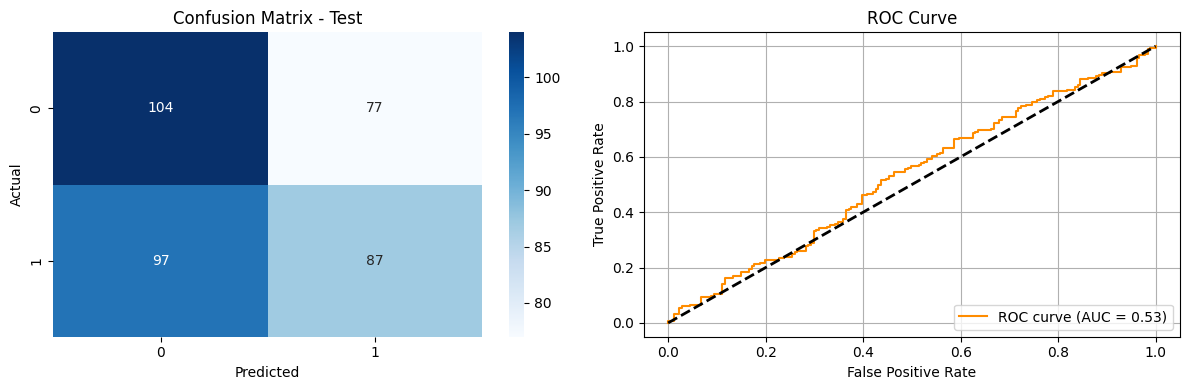

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix - Test')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

ax[1].plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange')
ax[1].plot([0, 1], [0, 1], 'k--', lw=2)
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC Curve')
ax[1].legend(loc="lower right")
ax[1].grid(True)

plt.tight_layout()
plt.show()

### *Model Interpretation:*

In [73]:
lr

,penalty,'l1'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'saga'
,max_iter,100
,multi_class,'deprecated'


In [74]:
coeff_df = pd.DataFrame({
    "Feature": X_train_scaled.columns,
    "Coefficient": lr.coef_[0]
}).sort_values(by="Coefficient", key=abs, ascending=False)

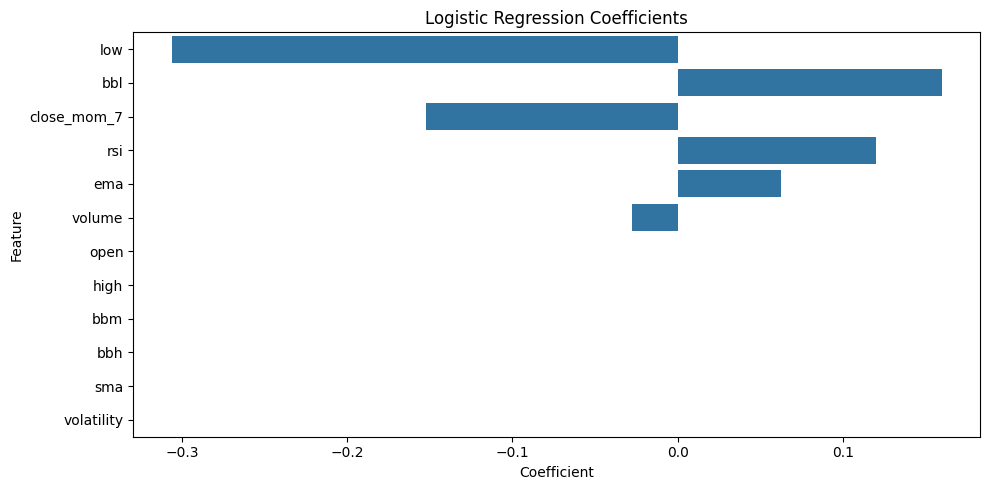

In [75]:
plt.figure(figsize=(10, 5))
sns.barplot(x="Coefficient", y="Feature", data=coeff_df)
plt.title("Logistic Regression Coefficients")
plt.tight_layout()
plt.show()

In [76]:
rf

,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [77]:
dt

,criterion,'gini'
,splitter,'best'
,max_depth,6
,min_samples_split,3
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [78]:
def plot_feature_importance(model, title):
    importances = pd.DataFrame({
        "Feature": X_train_scaled.columns,
        "Importance": model.feature_importances_
    }).sort_values("Importance", ascending=False)

    plt.figure(figsize=(10, 5))
    sns.barplot(x="Importance", y="Feature", data=importances)
    plt.title(title)
    plt.tight_layout()
    plt.show()

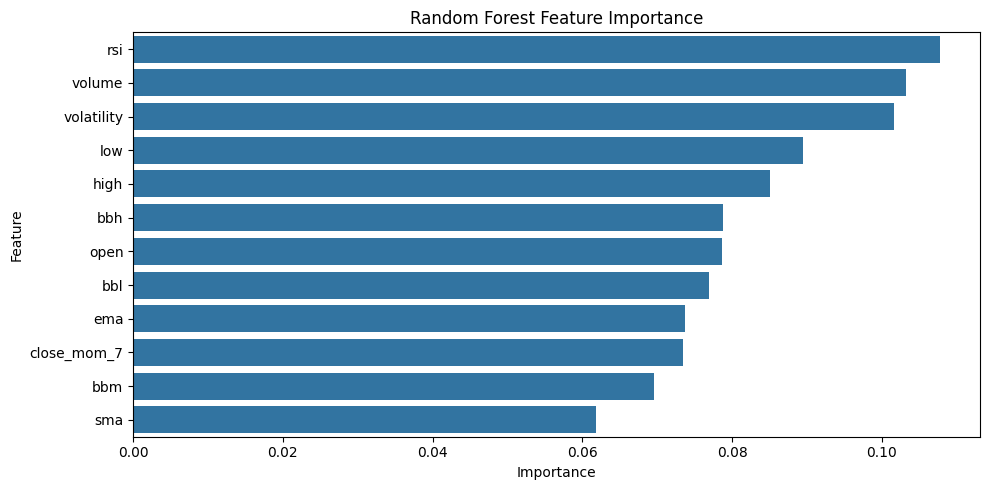

In [79]:
plot_feature_importance(rf, "Random Forest Feature Importance")

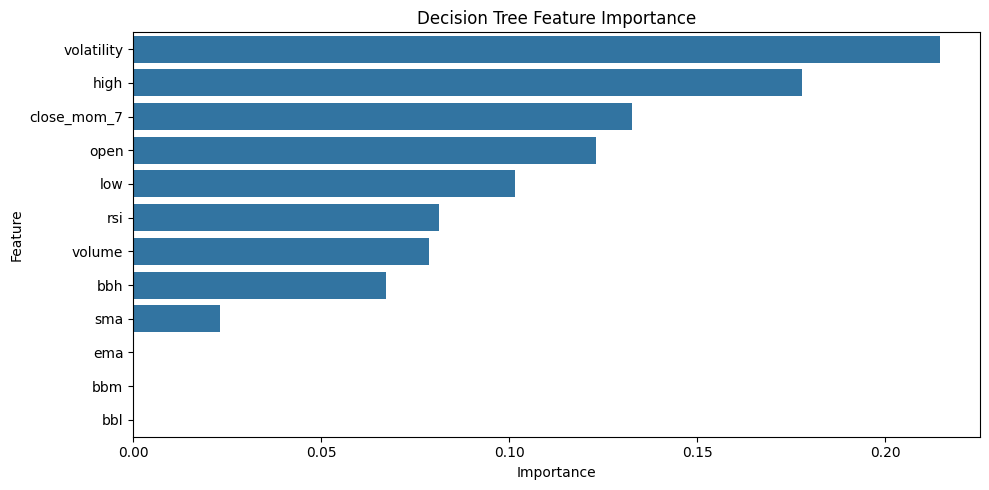

In [80]:
plot_feature_importance(dt, "Decision Tree Feature Importance")

### *Time Series Cross-Validation :*

In [81]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

tscv = TimeSeriesSplit(n_splits=5)
log_scores = cross_val_score(lr, X_train_scaled, y_train2, cv=tscv, scoring='f1')
rf_scores = cross_val_score(rf, X_train_scaled, y_train2, cv=tscv, scoring='f1')

In [82]:
log_scores

array([0.46280992, 0.65131579, 0.56944444, 0.57142857, 0.57875458])

In [83]:
rf_scores

array([0.52631579, 0.546875  , 0.57142857, 0.51405622, 0.52589641])

In [84]:
print("LogReg Time Series CV F1:", log_scores.mean())
print("Random Forest Time Series CV F1:", rf_scores.mean())

LogReg Time Series CV F1: 0.5667506602913301
Random Forest Time Series CV F1: 0.5369144000288967


### *Error Analysis :*

In [85]:
y_test_pred = lr.predict(X_test_scaled)

In [86]:
results = X_test_scaled.copy()
results['actual'] = y_test
results['predicted'] = y_test_pred
results['correct'] = (results['actual'] == results['predicted'])

# Identify false positives and false negatives
false_positives = results[(results['actual'] == 0) & (results['predicted'] == 1)]
false_negatives = results[(results['actual'] == 1) & (results['predicted'] == 0)]

In [87]:
def analyze_errors(error_df, label):
    print(f"{label} Analysis :\n")
    print("Count:", len(error_df))
    print("Avg Volume:", error_df['volume'].mean())
    print("Avg Volatility:", error_df['volatility'].mean())
    print("Avg RSI:", error_df['rsi'].mean())
    print("Avg close_mom_7:", error_df['close_mom_7'].mean())

In [88]:
analyze_errors(false_positives, "False Positives")

False Positives Analysis :

Count: 77
Avg Volume: 0.44940827614861983
Avg Volatility: -0.31586467849725697
Avg RSI: 0.8069439689038206
Avg close_mom_7: -0.005232915848862164


In [89]:
analyze_errors(false_negatives, "False Negatives")

False Negatives Analysis :

Count: 97
Avg Volume: 1.1999913342377684
Avg Volatility: -0.09450625264190401
Avg RSI: 0.13728513412709326
Avg close_mom_7: 0.25501075321091066


In [90]:
def plot_error_distribution(error_df, feature, label):
    plt.figure(figsize=(8, 4))
    sns.histplot(error_df[feature], kde=True, bins=30, color="salmon")
    plt.title(f"{feature} Distribution on {label}")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

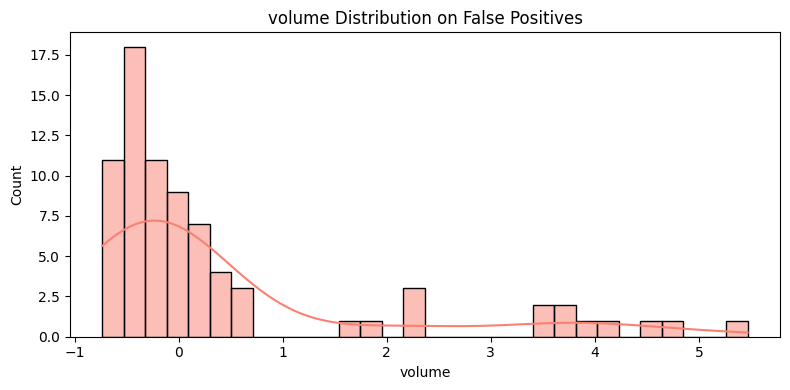

In [91]:
plot_error_distribution(false_positives, "volume", "False Positives")

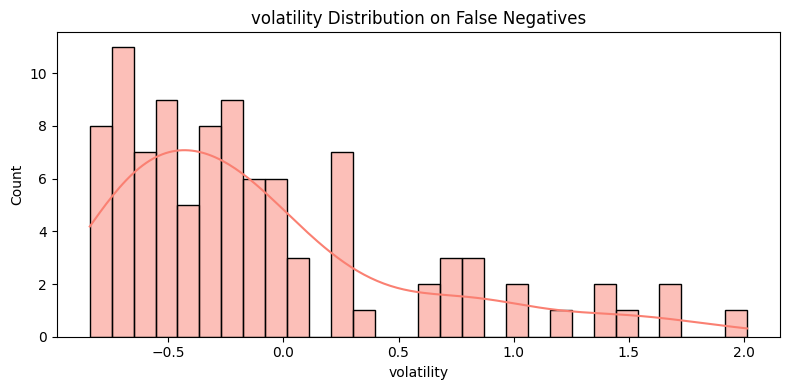

In [92]:
plot_error_distribution(false_negatives, "volatility", "False Negatives")

In [93]:
# View some specific days with large volume or volatility errors
false_positives.sort_values(by='volume', ascending=False).head()

,open,high,low,volume,sma,ema,bbh,bbm,bbl,volatility,rsi,close_mom_7,actual,predicted,correct
timestamp,,,,,,,,,,,,,,,
2023-02-09,0.15,0.12,0.12,5.47,0.17,0.16,0.10,0.17,0.24,-0.59,0.69,-0.35,0,1,False
2023-02-02,0.20,0.19,0.22,4.70,0.17,0.17,0.12,0.17,0.23,-0.48,1.70,0.23,0,1,False
2023-01-25,0.13,0.17,0.16,4.45,0.11,0.11,0.12,0.11,0.10,0.17,2.17,0.62,0,1,False
2023-02-03,0.18,0.16,0.21,4.23,0.17,0.17,0.12,0.17,0.23,-0.48,1.44,0.14,0,1,False
2023-02-01,0.16,0.17,0.18,3.87,0.16,0.16,0.10,0.16,0.23,-0.57,1.45,0.14,0,1,False


In [94]:
false_negatives.sort_values(by='volatility', ascending=False).head()

,open,high,low,volume,sma,ema,bbh,bbm,bbl,volatility,rsi,close_mom_7,actual,predicted,correct
timestamp,,,,,,,,,,,,,,,
2023-12-07,1.37,1.32,1.40,0.13,1.20,1.24,1.29,1.20,1.09,2.01,2.09,1.49,1,0,False
2023-03-18,0.41,0.39,0.42,4.98,0.21,0.25,0.35,0.21,0.06,1.69,1.57,3.42,1,0,False
2023-10-27,0.81,0.76,0.83,-0.35,0.70,0.71,0.79,0.70,0.58,1.68,2.43,1.78,1,0,False
2023-03-16,0.23,0.24,0.27,6.06,0.11,0.16,0.23,0.11,-0.02,1.47,0.69,1.10,1,0,False
2023-10-28,0.79,0.78,0.86,-0.62,0.73,0.73,0.80,0.73,0.65,1.41,2.21,1.30,1,0,False


### *Pipeline :*

In [95]:
X_train

,open,high,low,volume,sma,ema,bbh,bbm,bbl,volatility,rsi,close_mom_7
timestamp,,,,,,,,,,,,
2018-01-14,14210.00,14339.50,12569.20,17017.89,14506.92,14370.08,16249.23,14506.92,12764.61,940.96,49.66,-0.17
2018-01-15,13477.98,14249.99,13147.79,14652.09,14124.77,14146.31,15356.54,14124.77,12893.00,665.23,44.25,-0.17
2018-01-16,13500.00,13542.93,9035.00,63401.17,13930.11,13994.71,15032.60,13930.11,12827.63,595.41,44.83,-0.09
2018-01-17,10899.99,11680.99,9037.94,72331.80,13430.11,13221.04,15740.08,13430.11,11120.15,1247.52,30.94,-0.24
2018-01-18,10972.59,11878.82,10435.33,48464.43,12870.36,12662.97,15368.72,12870.36,10371.99,1349.27,31.71,-0.26
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,16919.39,16974.90,16594.90,172554.18,16844.26,16854.86,16933.00,16844.26,16755.53,47.92,48.61,0.03
2022-12-28,16706.06,16784.59,16467.50,190366.56,16817.15,16817.70,16936.71,16817.15,16697.59,64.57,44.81,-0.01
2022-12-29,16548.37,16662.53,16488.20,159076.17,16777.40,16750.19,16999.75,16777.40,16555.06,120.08,42.18,-0.02


In [96]:
y_train

timestamp
2018-01-14    1
2018-01-15    0
2018-01-16    1
2018-01-17    0
2018-01-18    1
             ..
2022-12-27    0
2022-12-28    1
2022-12-29    0
2022-12-30    0
2022-12-31    1
Name: target, Length: 1812, dtype: int64

In [97]:
# scaler = joblib.load('clf_x_scaler.pkl')
# lr = joblib.load('clf_lr.pkl')

# pipeline = Pipeline([
#     ('scaler', scaler),
#     ('model', lr)
# ])

# pipeline.fit(X_train, y_train)

In [98]:
# joblib.dump(pipeline, 'clf_lr_pipeline.pkl')

In [99]:
pipeline = joblib.load('clf_lr_pipeline.pkl')

In [100]:
pipeline

,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l1'
,dual,False
,tol,0.0001
,C,1.0


In [101]:
forecast_pred = pipeline.predict(X_forecast)

In [102]:
print("Accuracy Score:", accuracy_score(y_forecast, forecast_pred))
print("F1 Score (weighted):", f1_score(y_forecast, forecast_pred, average='weighted'))
print("Recall Score (weighted):", recall_score(y_forecast, forecast_pred, average='weighted'))
print("Precision Score (weighted):", precision_score(y_forecast, forecast_pred, average='weighted'))
print("ROC AUC Score:", roc_auc_score(y_forecast, lr.predict_proba(X_forecast_scaled)[:, 1]))

Accuracy Score: 0.49107142857142855
F1 Score (weighted): 0.39885560375189216
Recall Score (weighted): 0.49107142857142855
Precision Score (weighted): 0.5359859821796558
ROC AUC Score: 0.5311160857051487


In [103]:
report = classification_report(y_forecast, forecast_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.91      0.63       265
           1       0.59      0.12      0.19       295

    accuracy                           0.49       560
   macro avg       0.53      0.51      0.41       560
weighted avg       0.54      0.49      0.40       560



In [104]:
forecast_pred = pipeline.predict(X_forecast)
y_prob = pipeline.predict_proba(X_forecast)[:,1]

cm_test = confusion_matrix(y_forecast, forecast_pred)

fpr, tpr, thresholds = roc_curve(y_forecast, y_prob)
roc_auc = auc(fpr, tpr)

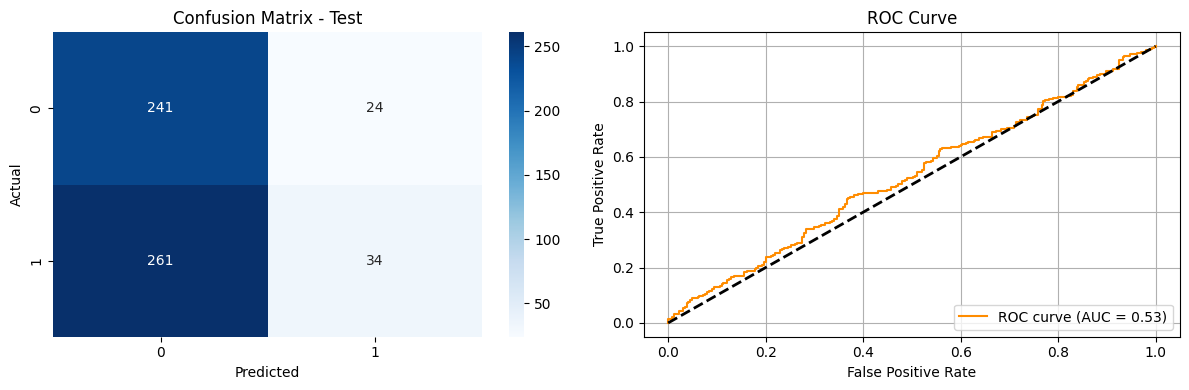

In [105]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix - Test')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

ax[1].plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange')
ax[1].plot([0, 1], [0, 1], 'k--', lw=2)
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC Curve')
ax[1].legend(loc="lower right")
ax[1].grid(True)

plt.tight_layout()
plt.show()

### *Forcasting [2024-2025]:*

In [106]:
X_forecast_scaled

,open,high,low,volume,sma,ema,bbh,bbm,bbl,volatility,rsi,close_mom_7
timestamp,,,,,,,,,,,,
2024-01-01,1.29,1.33,1.36,-0.50,1.31,1.31,1.20,1.31,1.43,-0.20,0.04,-0.25
2024-01-02,1.40,1.43,1.48,0.12,1.32,1.33,1.23,1.32,1.42,0.00,0.71,0.04
2024-01-03,1.44,1.41,1.23,0.67,1.34,1.36,1.28,1.34,1.40,0.41,0.93,0.52
2024-01-04,1.32,1.37,1.38,-0.05,1.33,1.35,1.28,1.33,1.39,0.40,0.09,-0.15
2024-01-05,1.40,1.34,1.35,-0.03,1.35,1.36,1.29,1.35,1.40,0.47,0.47,0.33
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-09,5.20,5.20,5.38,-0.87,5.20,5.19,4.82,5.20,5.62,-0.23,0.43,0.23
2025-07-10,5.34,5.50,5.51,-0.83,5.22,5.23,4.89,5.22,5.57,0.41,0.86,0.14
2025-07-11,5.62,5.59,5.79,-0.87,5.27,5.33,5.12,5.27,5.43,2.45,1.48,0.52


In [107]:
lr

,penalty,'l1'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'saga'
,max_iter,100
,multi_class,'deprecated'


In [108]:
forecast_pred = lr.predict(X_forecast_scaled)

print("Accuracy Score:", accuracy_score(y_forecast, forecast_pred))
print("F1 Score (weighted):", f1_score(y_forecast, forecast_pred, average='weighted'))
print("Recall Score (weighted):", recall_score(y_forecast, forecast_pred, average='weighted'))
print("Precision Score (weighted):", precision_score(y_forecast, forecast_pred, average='weighted'))
print("ROC AUC Score:", roc_auc_score(y_forecast, lr.predict_proba(X_forecast_scaled)[:, 1]))


Accuracy Score: 0.4785714285714286
F1 Score (weighted): 0.3304091228968076
Recall Score (weighted): 0.4785714285714286
Precision Score (weighted): 0.5491040038572031
ROC AUC Score: 0.5311160857051487


In [109]:
from sklearn.metrics import classification_report

report = classification_report(y_forecast, forecast_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.98      0.64       265
           1       0.62      0.03      0.05       295

    accuracy                           0.48       560
   macro avg       0.55      0.50      0.35       560
weighted avg       0.55      0.48      0.33       560



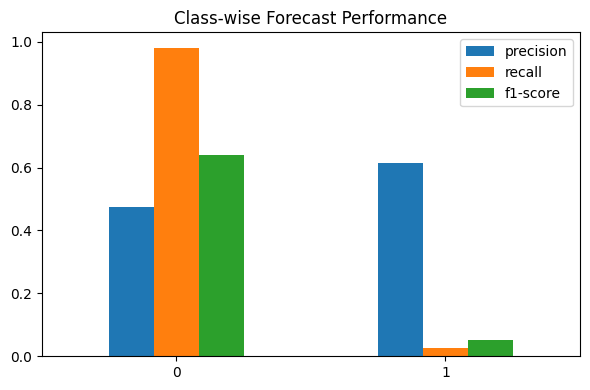

In [110]:
report = classification_report(y_forecast, forecast_pred, output_dict=True)
metrics_df = pd.DataFrame(report).T.loc[['0', '1'], ['precision', 'recall', 'f1-score']]

metrics_df.plot(kind='bar', figsize=(6, 4))
plt.title("Class-wise Forecast Performance")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [111]:
forecast_pred = lr.predict(X_forecast_scaled)
y_prob = lr.predict_proba(X_forecast_scaled)[:, 1]

cm_test = confusion_matrix(y_forecast, forecast_pred)

fpr, tpr, thresholds = roc_curve(y_forecast, y_prob)
roc_auc = auc(fpr, tpr)

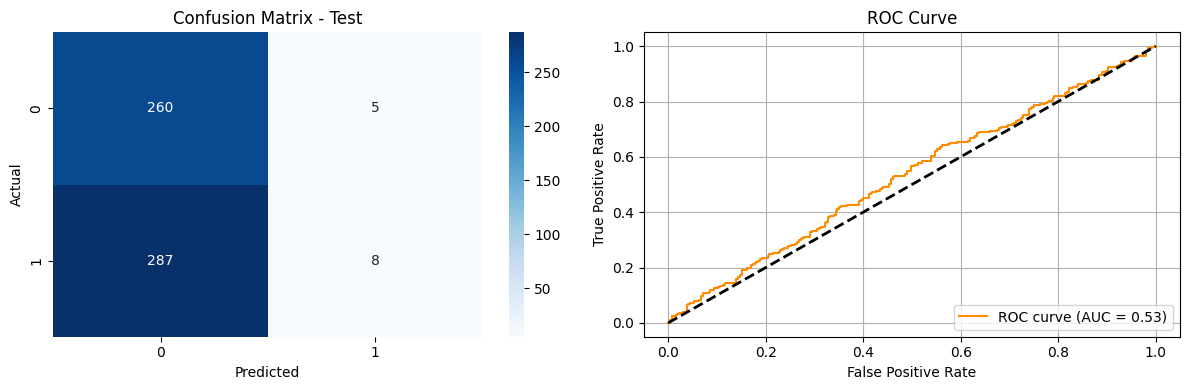

In [112]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix - Test')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

ax[1].plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange')
ax[1].plot([0, 1], [0, 1], 'k--', lw=2)
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC Curve')
ax[1].legend(loc="lower right")
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [113]:
X_forecast

,open,high,low,volume,sma,ema,bbh,bbm,bbl,volatility,rsi,close_mom_7
timestamp,,,,,,,,,,,,
2024-01-01,42283.58,44188.28,42180.81,26548.61,42654.10,42545.86,43781.18,42654.10,41527.03,608.69,51.26,-0.02
2024-01-02,44181.40,45996.20,44148.34,66341.09,42740.31,42954.28,44184.08,42740.31,41296.53,779.73,60.38,0.01
2024-01-03,44955.90,45512.52,39925.40,101430.93,43089.87,43454.69,45180.37,43089.87,40999.38,1128.99,63.40,0.06
2024-01-04,42845.23,44891.91,42393.30,55234.61,43006.06,43302.32,45081.98,43006.06,40930.15,1121.12,51.83,-0.01
2024-01-05,44140.67,44312.40,42000.00,56331.10,43232.63,43514.18,45409.73,43232.63,41055.54,1175.76,57.05,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-09,108924.10,111998.05,108328.13,2605.12,108712.78,108413.65,109797.75,108712.78,107627.82,585.95,56.59,0.03
2025-07-10,111241.23,117238.05,110513.28,5235.34,109058.45,109121.88,111146.61,109058.45,106970.29,1127.73,62.40,0.02
2025-07-11,116004.58,118842.56,115218.77,3110.92,109972.12,110837.17,115288.26,109972.12,104655.98,2871.04,70.95,0.06


In [114]:
rf

,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [115]:
forecast_pred = rf.predict(X_forecast_scaled)

print("Accuracy Score:", accuracy_score(y_forecast, forecast_pred))
print("F1 Score (weighted):", f1_score(y_forecast, forecast_pred, average='weighted'))
print("Recall Score (weighted):", recall_score(y_forecast, forecast_pred, average='weighted'))
print("Precision Score (weighted):", precision_score(y_forecast, forecast_pred, average='weighted'))
print("ROC AUC Score:", roc_auc_score(y_forecast, lr.predict_proba(X_forecast_scaled)[:, 1]))

Accuracy Score: 0.48392857142857143
F1 Score (weighted): 0.416942090098826
Recall Score (weighted): 0.48392857142857143
Precision Score (weighted): 0.5059277322254017
ROC AUC Score: 0.5311160857051487


In [116]:
forecast_pred = rf.predict(X_forecast_scaled)
y_prob = rf.predict_proba(X_forecast_scaled)[:, 1]

cm_test = confusion_matrix(y_forecast, forecast_pred)

fpr, tpr, thresholds = roc_curve(y_forecast, y_prob)
roc_auc = auc(fpr, tpr)

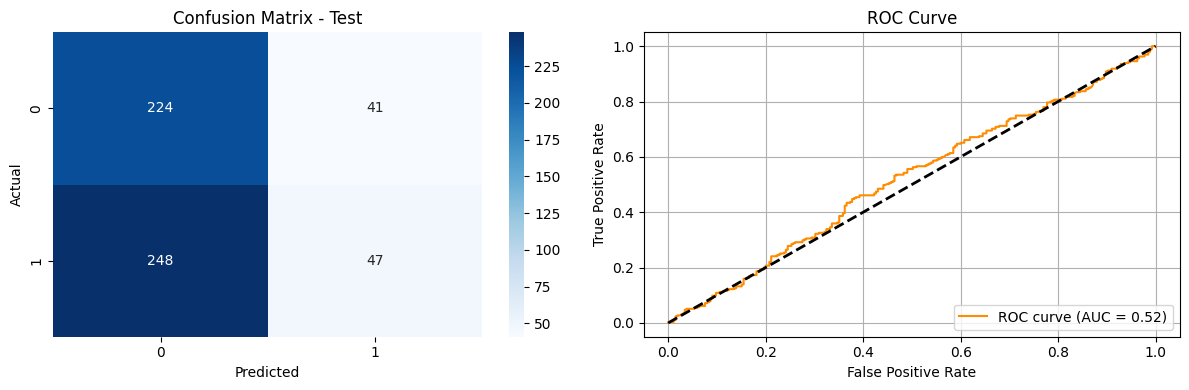

In [117]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix - Test')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

ax[1].plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange')
ax[1].plot([0, 1], [0, 1], 'k--', lw=2)
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC Curve')
ax[1].legend(loc="lower right")
ax[1].grid(True)

plt.tight_layout()
plt.show()

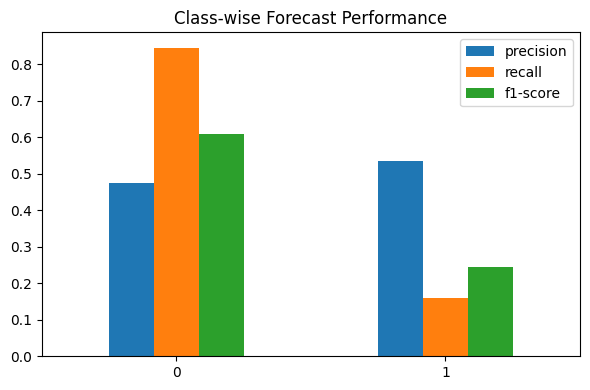

In [118]:
report = classification_report(y_forecast, forecast_pred, output_dict=True)
metrics_df = pd.DataFrame(report).T.loc[['0', '1'], ['precision', 'recall', 'f1-score']]

metrics_df.plot(kind='bar', figsize=(6, 4))
plt.title("Class-wise Forecast Performance")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [119]:
forecast_df = X_forecast.copy()
forecast_df = forecast_df.tail(30)

forecast_df['Actual'] = y_forecast[-30:].values
forecast_df['Predicted'] = forecast_pred[-30:]

forecast_df['close'] = df.loc[forecast_df.index, 'close']

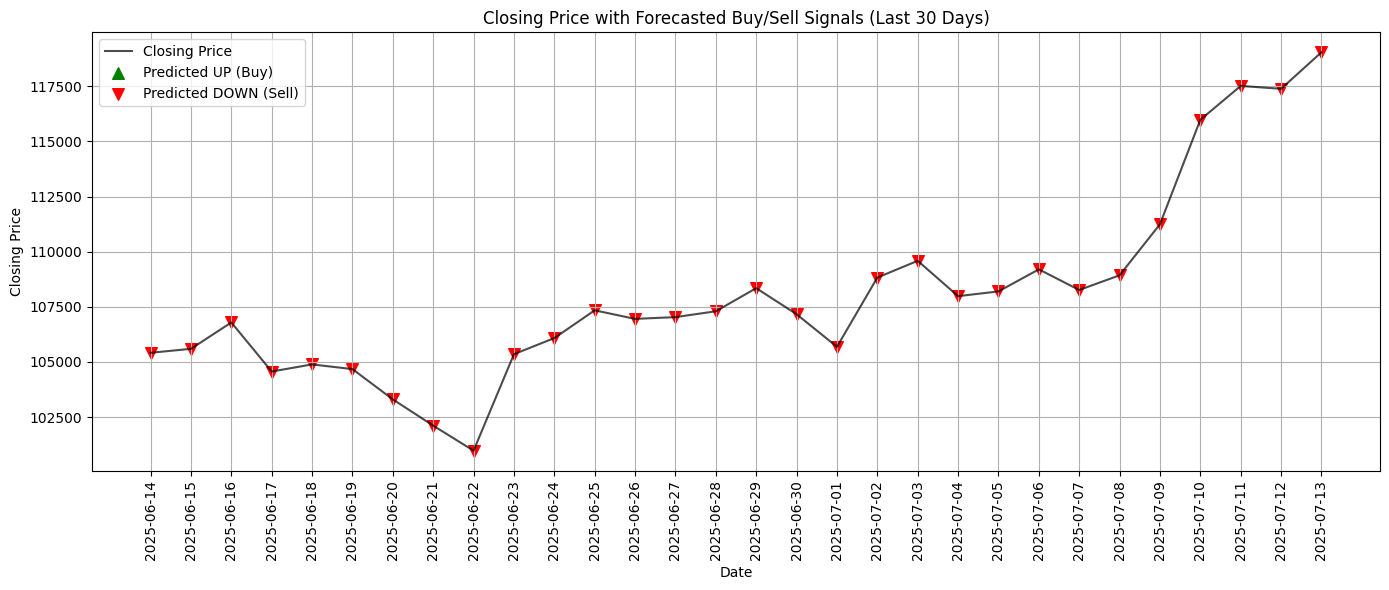

In [120]:
plt.figure(figsize=(14, 6))
plt.plot(forecast_df.index, forecast_df['close'], label='Closing Price', color='black', alpha=0.7)

buy_signals = forecast_df[forecast_df['Predicted'] == 1]
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Predicted UP (Buy)', s=70)

sell_signals = forecast_df[forecast_df['Predicted'] == 0]
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', label='Predicted DOWN (Sell)', s=70)

plt.title("Closing Price with Forecasted Buy/Sell Signals (Last 30 Days)")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()